# Preamble

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import sys
sys.path.append('..') #hack to import from parent directory
from plot_utils import visualize_tree, plot_results


In [3]:
titanic = pd.read_csv('Titanic.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Ready datasets

First clean up the data a little

In [4]:
#one-hot encode categorical features
male_column = pd.get_dummies(titanic["Sex"])[['male']]
embark_columns = pd.get_dummies(titanic["Embarked"])

#replace categorical features with new features
titanic = pd.concat([titanic, male_column, embark_columns], axis='columns').drop(['Sex', 'Embarked'], axis='columns')

#drop non-categorical text features and primary key
titanic = titanic.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis='columns')

#drop data with NaN values
titanic = titanic.dropna()

titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
0,0,3,22.0,1,0,7.2500,True,False,False,True
1,1,1,38.0,1,0,71.2833,False,True,False,False
2,1,3,26.0,0,0,7.9250,False,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
885,0,3,39.0,0,5,29.1250,False,False,True,False
886,0,2,27.0,0,0,13.0000,True,False,False,True
887,1,1,19.0,0,0,30.0000,False,False,False,True
889,1,1,26.0,0,0,30.0000,True,True,False,False


Train and test sets

In [5]:
y = titanic['Survived']
X = titanic.drop('Survived', axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=504)


# Training a random forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=504, max_depth=4, min_samples_split=6, max_features=3, )
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=3, min_samples_split=6,
                       random_state=504)

In [7]:
forest_clf.score(X_train, y_train)

0.8528896672504378

In [8]:
forest_clf.score(X_test, y_test)


0.8251748251748252

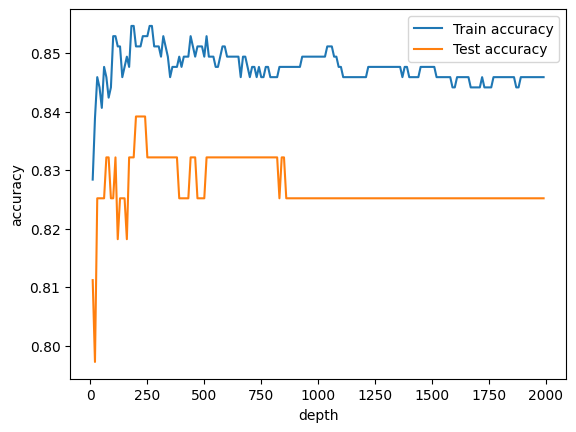

In [17]:
# Trying more trees
ensembles = [n * 10 for n in range(1, 31)]

classifiers = [RandomForestClassifier(random_state=504, max_depth=4, min_samples_split=6, max_features=3, n_estimators=n) for n in ensembles]
for clf in classifiers: clf.fit(X_train, y_train)

train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]
plot_results(train_scores, test_scores, train_label="Train accuracy", test_label="Test accuracy", xlabel="depth", ylabel="accuracy", xvalues = ensembles)

In [14]:
forest_clf = RandomForestClassifier(random_state=504, max_depth=4, min_samples_split=6, n_estimators=220)
forest_clf.fit(X_train, y_train)

forest_clf.score(X_train, y_train), forest_clf.score(X_test, y_test)

(0.8493870402802102, 0.8251748251748252)

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': ensembles}

gsc = GridSearchCV(RandomForestClassifier(random_state=504, max_depth=4, min_samples_split=6, max_features=3), params, n_jobs=12)
gsc.fit(X_train, y_train)
gsc.best_estimator_

RandomForestClassifier(max_depth=4, max_features=3, min_samples_split=6,
                       n_estimators=290, random_state=504)

In [12]:
gsc.score(X_test, y_test)

0.8321678321678322

In [13]:
importances = zip(X_train.keys(), gsc.best_estimator_.feature_importances_) #pairs up feature names with performance score
sorted(importances, key=lambda p: -p[1])

[('male', 0.46288344289398714),
 ('Fare', 0.16656905335162753),
 ('Pclass', 0.16204556732958003),
 ('Age', 0.09665616952973104),
 ('Parch', 0.03881906986777666),
 ('SibSp', 0.03486799163470466),
 ('C', 0.021055994846512195),
 ('S', 0.013318726805632376),
 ('Q', 0.0037839837404482855)]